In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree
from sklearn.model_selection import train_test_split

In [69]:
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import xgboost as xgb

In [91]:
from imblearn.over_sampling import SMOTE

<h3>(a) Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/
APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test
set. The training set contains 60,000 rows, of which 1,000 belong to the positive
class and 171 columns, of which one is the class column. All attributes are numeric.

In [3]:
df = pd.read_csv("../data/aps_failure_training_set.csv", skiprows = [i for i in range(0,20)])

In [4]:
test = pd.read_csv("../data/aps_failure_test_set.csv", skiprows = [i for i in range(0,20)])

In [5]:
test.shape

(16000, 171)

In [6]:
df.shape

(60000, 171)

In [7]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


<h3>(b) Data Preparation
This data set has missing values. When the number of data with missing values
is significant, discarding them is not a good idea. 1
i. Research what types of techniques are usually used for dealing with data with
missing values.2 Pick at least one of them and apply it to this data in the
next steps.3



Ways to handle missing values.<br>
Replace missing values with a constant with a meaning in that domain.<br>
Replace with statistics such as Mean, Median, Mode to fill out missing values.<br>
Replace using predicted values of a ML model for that feature.

<br> Here we use mean of the columns to fill out the missing values in that column.

In [8]:
df['class'].value_counts()#no missing data in 'class' column

neg    59000
pos     1000
Name: class, dtype: int64

In [9]:
l = list(df.columns)
l.remove('class')

In [ ]:
# train_X = df[l]
# train_y = df[['class']]
# test_X = test[l]
# test_y = test[['class']]

In [10]:
df = df.applymap( lambda x: np.nan if x == 'na' else x)
df = df.apply( pd.to_numeric, errors='ignore')
df = df.fillna( value = df.mean(), axis = 0)

In [11]:
test = test.applymap( lambda t: np.nan if t == 'na' else t)
test = test.apply( pd.to_numeric, errors='ignore')
test = test.fillna( value = test.mean(), axis = 0)

<h3>ii. For each of the 170 features, calculate the coefficient of variation CV =
s
m
,
where s is sample standard deviation and m is sample mean.


In [12]:
new_df = pd.concat([df,test])

In [13]:
mean = new_df.mean(axis=0).to_frame()
mean.columns = ['mean']

In [14]:
std = new_df.std(axis=0).to_frame()
std.columns = ['std']

In [17]:
cv = pd.concat([std, mean], axis=1)
cv['coeff_var'] = cv['std'] / cv['mean'] 
cv.head()

,std,mean,coeff_var
aa_000,2.647366e+05,6.115976e+04,4.328608
ab_000,1.580609e+00,7.255835e-01,2.178397
ac_000,7.726379e+08,3.564406e+08,2.167648
ad_000,3.113848e+07,1.505825e+05,206.786809
ae_000,1.501916e+02,6.736860e+00,22.293998


<h3>iii. Plot a correlation matrix for your features using pandas or any other tool.


<AxesSubplot:>

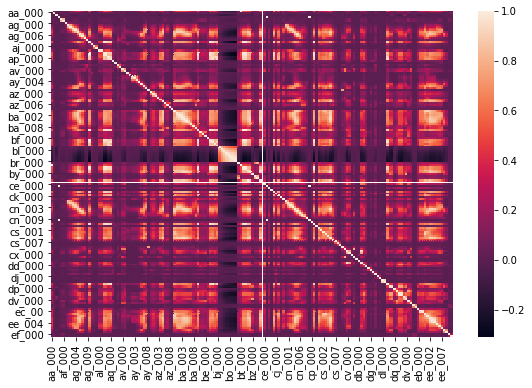

In [18]:
corr = new_df.corr()
plt.figure(figsize=(9, 6))
sns.heatmap(corr)

<h3>iv. Pick b
√
170c features with highest CV , and make scatter plots and box plots
for them, similar to those on p. 129 of ISLR. Can you draw conclusions about
significance of those features, just by the scatter plots? This does not mean
that you will only use those features in the following questions. We picked
them only for visualization.


In [19]:
sortdf = cv.sort_values(by=['coeff_var'], ascending=False)
new_cv = list(sortdf.iloc[:int(math.sqrt(170)),:].index)
new_cv

['cf_000',
 'co_000',
 'ad_000',
 'cs_009',
 'dj_000',
 'as_000',
 'dh_000',
 'df_000',
 'ag_000',
 'au_000',
 'ak_000',
 'az_009',
 'ay_009']

In [20]:
new_cv_df = new_df.loc[:, new_cv]
new_cv_df.head()

,cf_000,co_000,ad_000,cs_009,dj_000,as_000,dh_000,df_000,ag_000,au_000,ak_000,az_009,ay_009
0,2.000000,220.000000,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,190221.810984,190515.566938,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.000000,2.000000,66.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,202.000000,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
print('Total Predictors used: ',new_cv_df.shape[1] )


Total Predictors used:  13


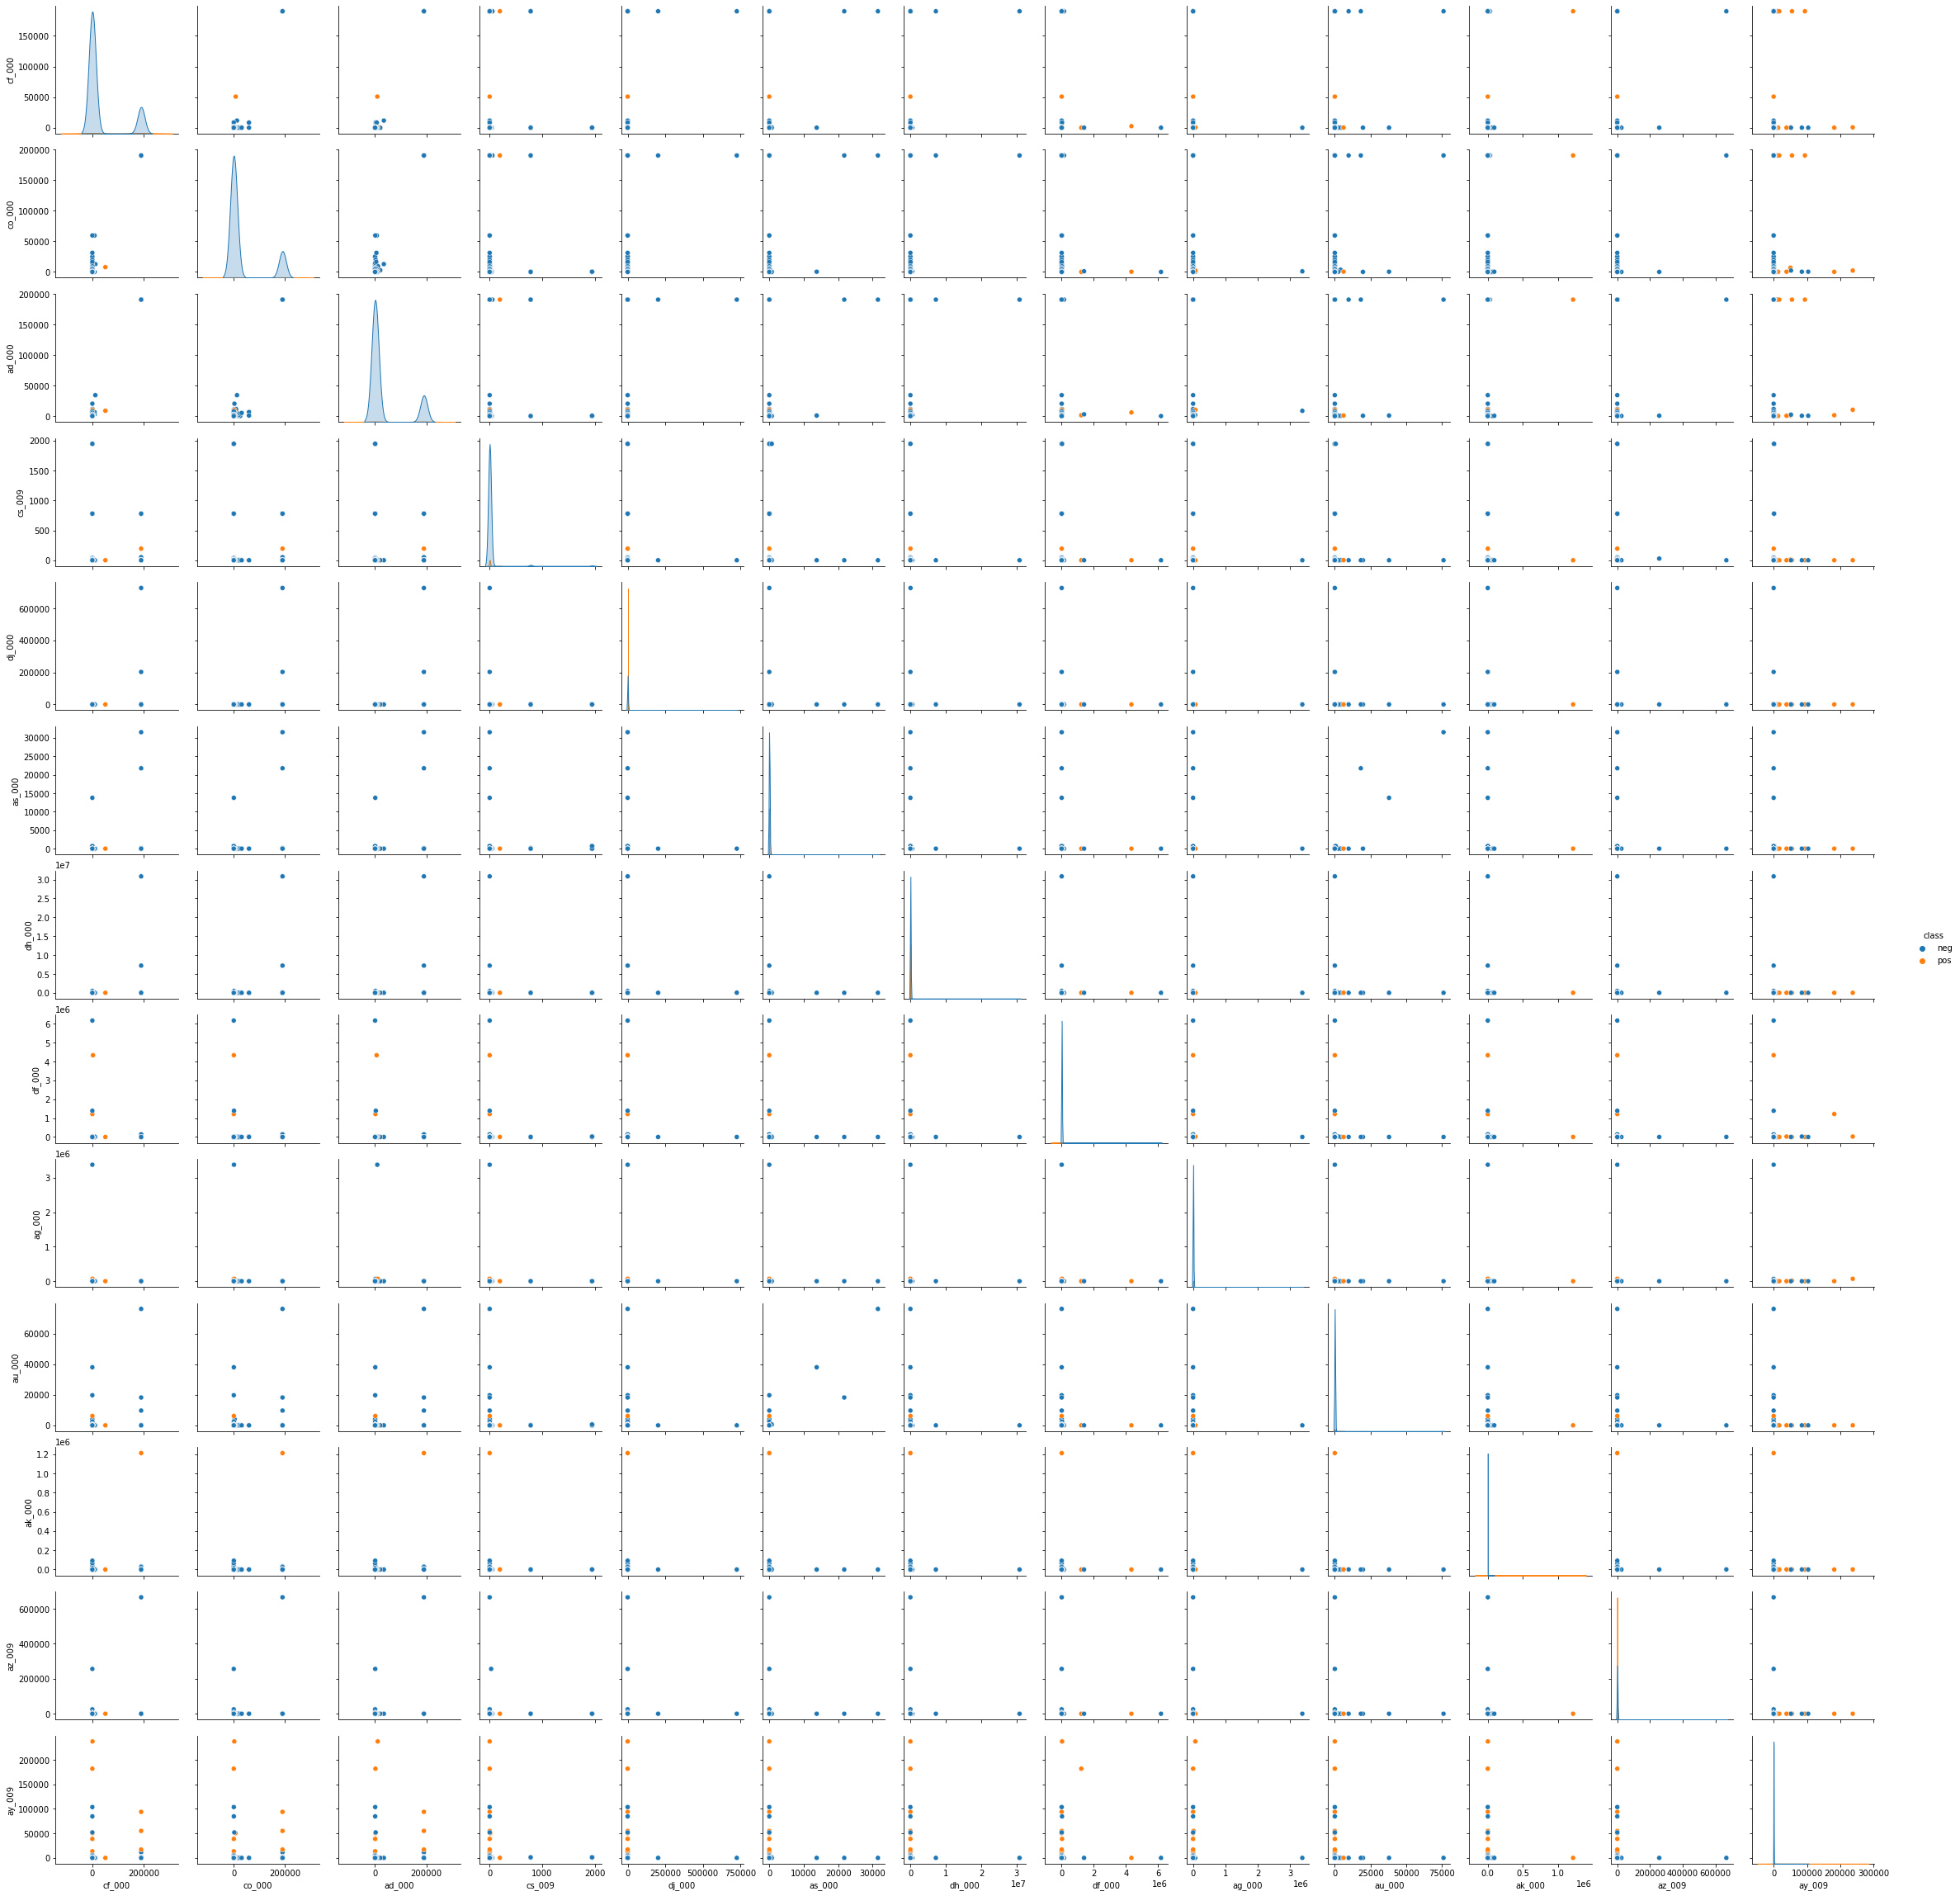

In [25]:
pp = new_cv_df
pp['class'] = new_df['class']
sns.pairplot(pp, hue = 'class', diag_kind='kde')

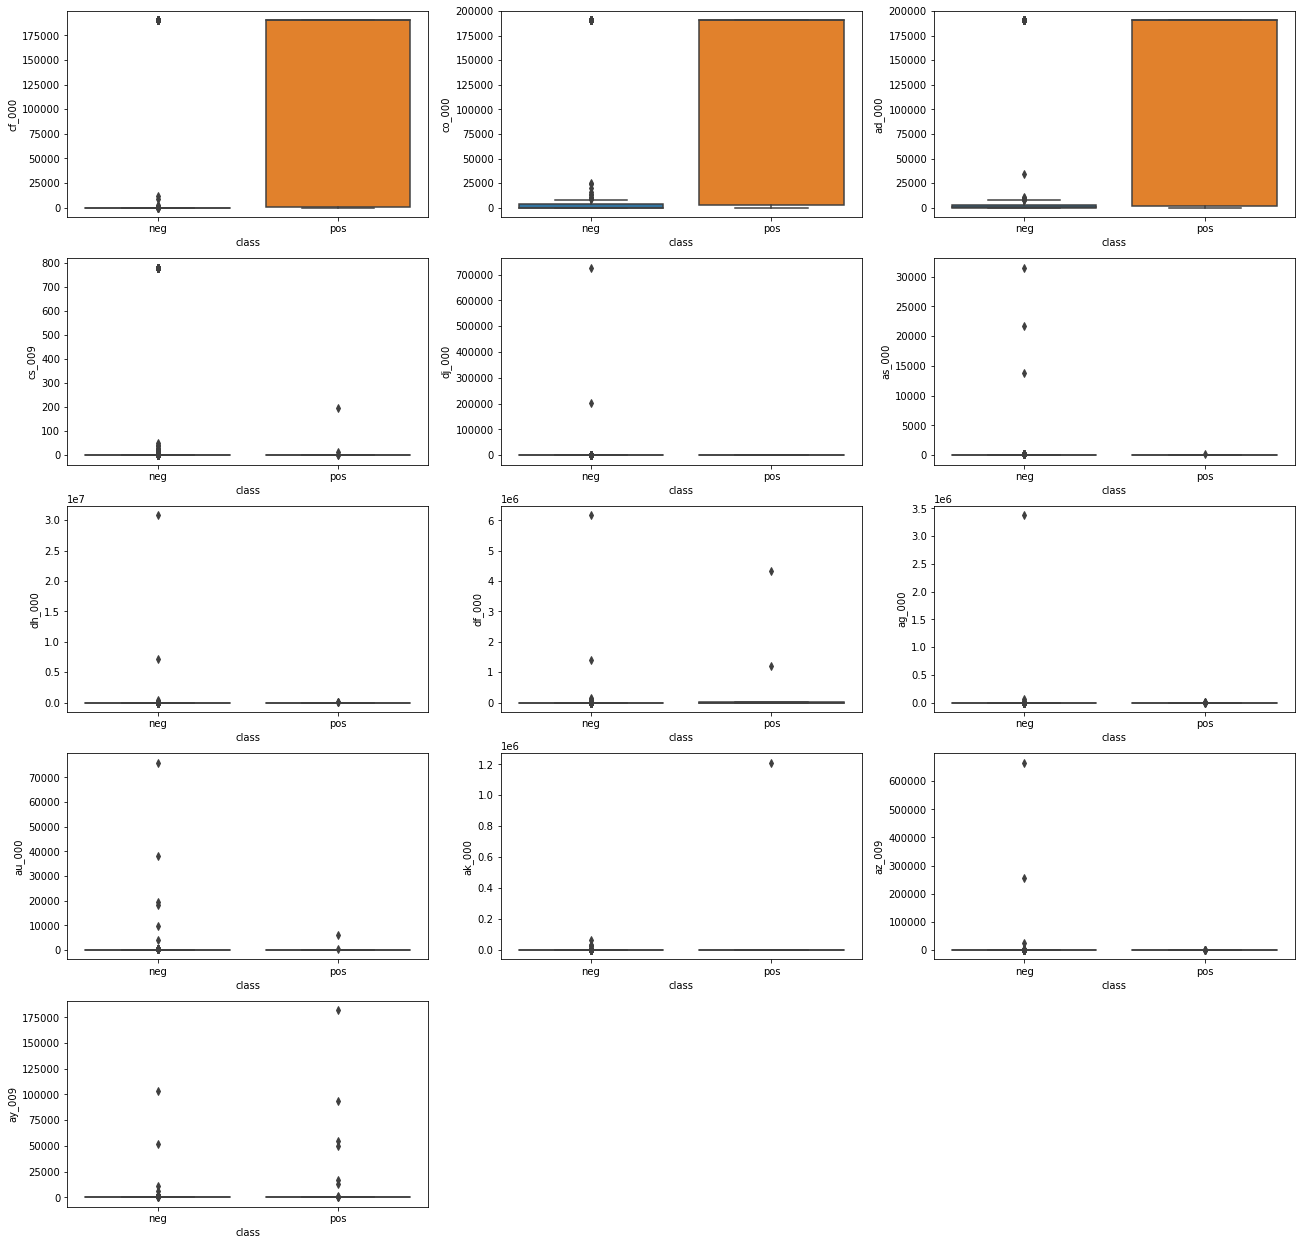

In [27]:
plt.figure(figsize=(22,22))
subplt = 1

for i in range(0,len(new_cv)):
    plt.subplot(5,3, subplt)
    sns.boxplot(x = 'class', y = new_cv[i], data=new_df)
    subplt += 1

<h3>v. Determine the number of positive and negative data. Is this data set imbalanced?

In [28]:
neg = new_df[new_df['class'] == 'neg'].shape[0]
pos = new_df[new_df['class'] == 'pos'].shape[0]

In [29]:
print('Total Negative:',neg)
print('Total Positive:',pos)

Total Negative: 74625
Total Positive: 1375


Negative is drastically more than positive hence the data is imbalanced. The ratio is around 2:98.

<h3>(c) Train a random forest to classify the data set. Do NOT compensate for class
imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and
misclassification for training and test sets and report them (You may use pROC
package). Calculate Out of Bag error estimate for your random forset and compare
it to the test error.


In [37]:
train_X = df[l]
train_y = df[['class']]
test_X = test[l]
test_y = test[['class']]
test_y = test_y.replace('neg', 0)
test_y = test_y.replace('pos', 1)
train_y = train_y.replace('neg', 0)
train_y = train_y.replace('pos', 1)


In [38]:
rfcmodel = RandomForestClassifier(n_estimators=100, oob_score=True)
rfcmodel = rfcmodel.fit(train_X, train_y)
rfctrain_pred = rfcmodel.predict(train_X)
rfctest_pred = rfcmodel.predict(test_X)

In [39]:
rfctrain_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [40]:
print("Train Error: ", mean_squared_error(rfctrain_pred, train_y))
print("Test Error: ", mean_squared_error(rfctest_pred, test_y))
print("Out of bag error:", 1 - rfcmodel.oob_score_)

Train Error:  0.0
Test Error:  0.00725
Out of bag error: 0.006316666666666637


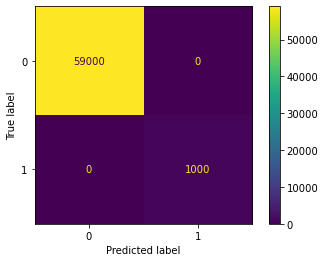

In [41]:
ConfusionMatrixDisplay(confusion_matrix(rfctrain_pred, train_y)).plot()

In [42]:
tn, fp, fn, tp = confusion_matrix(rfctrain_pred, train_y).ravel()
print('Misclassification in training set', fp + fn)

Misclassification in training set 0


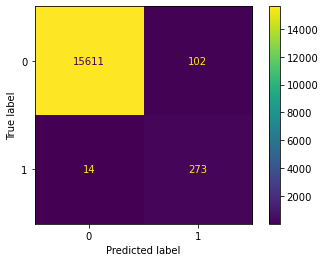

In [43]:
ConfusionMatrixDisplay(confusion_matrix(rfctest_pred, test_y)).plot()

In [44]:
tn, fp, fn, tp = confusion_matrix(rfctest_pred, test_y).ravel()
print('Misclassification in testing set', fp + fn)

Misclassification in testing set 116


In [45]:
a, b, c = roc_curve(rfctrain_pred, train_y)
print("AUC FOR TRAINING DATA", roc_auc_score(rfctrain_pred, train_y))

AUC FOR TRAINING DATA 1.0


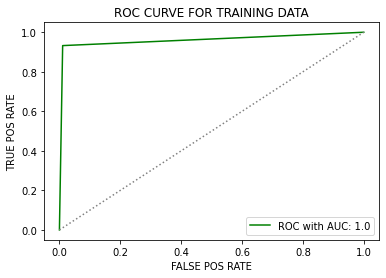

In [64]:
plt.plot(a, b, color='green', label='ROC with AUC: ' + str(roc_auc_score(rfctrain_pred, train_y)))
plt.plot([0, 1], [0, 1], color='grey', linestyle = 'dotted')
plt.xlabel('FALSE POS RATE')
plt.ylabel('TRUE POS RATE')
plt.title('ROC CURVE FOR TRAINING DATA')
plt.legend()
plt.show()

In [47]:
a, b, c = roc_curve(rfctest_pred, test_y)
print("AUC FOR TESTING DATA", roc_auc_score(rfctest_pred, test_y))

AUC FOR TESTING DATA 0.9723640359931888


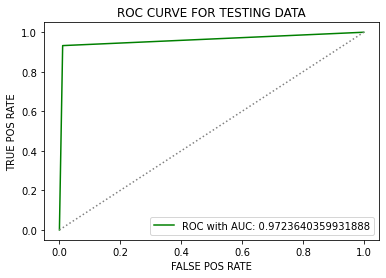

In [65]:
plt.plot(a, b, color='green', label='ROC with AUC: ' + str(roc_auc_score(rfctest_pred, test_y)))
plt.plot([0, 1], [0, 1], color='grey', linestyle = 'dotted')
plt.xlabel('FALSE POS RATE')
plt.ylabel('TRUE POS RATE')
plt.title('ROC CURVE FOR TESTING DATA')
plt.legend()
plt.show()

<h3>(d) Research how class imbalance is addressed in random forests. Compensate for
class imbalance in your random forest and repeat 2c. Compare the results with
those of 2c.

In [49]:
balrfc = RandomForestClassifier(n_estimators=100, oob_score=True, class_weight='balanced')
balrfc = balrfc.fit(train_X, train_y)
balrfctrain_pred = balrfc.predict(train_X)
balrfctest_pred = balrfc.predict(test_X)

In [51]:
print("Train Error: ", mean_squared_error(balrfctrain_pred, train_y))
print("Test Error: ", mean_squared_error(balrfctest_pred, test_y))
print("Out of bag error:", 1 - balrfc.oob_score_)

Train Error:  0.0
Test Error:  0.0114375
Out of bag error: 0.00773333333333337


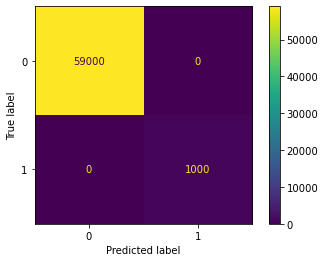

In [52]:
ConfusionMatrixDisplay(confusion_matrix(balrfctrain_pred, train_y)).plot()

In [53]:
tn, fp, fn, tp = confusion_matrix(balrfctrain_pred, train_y).ravel()
print('Misclassification in training set', fp + fn)

Misclassification in training set 0


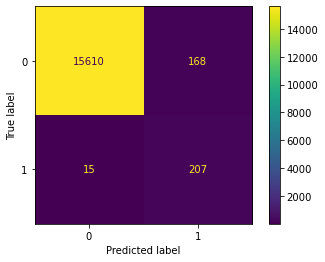

In [54]:
ConfusionMatrixDisplay(confusion_matrix(balrfctest_pred, test_y)).plot()

In [55]:
tn, fp2, fn2, tp = confusion_matrix(balrfctest_pred, test_y).ravel()
print('Misclassification in training set', fp2 + fn2)

Misclassification in training set 183


In [58]:
a, b, c = roc_curve(balrfctrain_pred, train_y)
print("AUC FOR TRAINING DATA", roc_auc_score(balrfctrain_pred, train_y))

AUC FOR TRAINING DATA 1.0


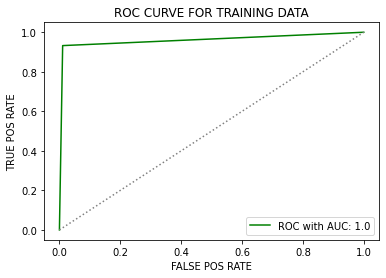

In [62]:
plt.plot(a, b, color='green', label='ROC with AUC: ' + str(roc_auc_score(balrfctrain_pred, train_y)))
plt.plot([0, 1], [0, 1], color='grey', linestyle = 'dotted')
plt.xlabel('FALSE POS RATE')
plt.ylabel('TRUE POS RATE')
plt.title('ROC CURVE FOR TRAINING DATA')
plt.legend()
plt.show()

In [60]:
a, b, c = roc_curve(balrfctest_pred, test_y)
print("AUC FOR TESTING DATA", roc_auc_score(balrfctest_pred, test_y))

AUC FOR TESTING DATA 0.9608923475383103


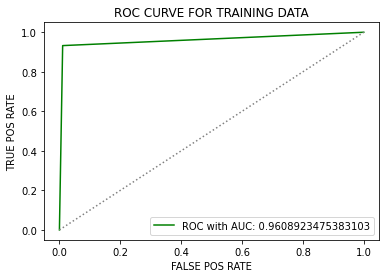

In [63]:
plt.plot(a, b, color='green', label='ROC with AUC: ' + str(roc_auc_score(balrfctest_pred, test_y)))
plt.plot([0, 1], [0, 1], color='grey', linestyle = 'dotted')
plt.xlabel('FALSE POS RATE')
plt.ylabel('TRUE POS RATE')
plt.title('ROC CURVE FOR TRAINING DATA')
plt.legend()
plt.show()

<h3>(e) XGBoost and Model Trees
In the case of a univariate tree, only one input dimension is used at a tree split.
In a multivariate tree, or model tree, at a decision node all input dimensions can
be used and thus it is more general. In univariate classification trees, majority
polling is used at each node to determine the split of that node as the decision
rule. In model trees, a (linear) model that relies on all of the variables is used
to determine the split of that node (i.e. instead of using Xj > s as the decision
rule, one has P
j
βjXj > s. as the decision rule). Alternatively, in a regression
tree, instead of using average in the region associated with each node, a linear
regression model is used to determine the value associated with that node.
One of the methods that can be used at each node is Logistic Regression. Because
the number of variables is large in this problem, one can use L1-penalized logistic
regression at each node. You can use XGBoost to fit the model tree. Determine
α (the regularization term) using cross-validation. Train the model for the APS
data set without compensation for class imbalance. Use one of 5 fold, 10 fold,
and leave-one-out cross validation methods to estimate the error of your trained
model and compare it with the test error. Report the Confusion Matrix, ROC,
and AUC for training and test sets.

In [70]:
modxgb = xgb.XGBRegressor(objective='reg:squarederror')
alpha = {'reg_alpha': np.linspace(0.5, 1, 3)}
modxgb = GridSearchCV(modxgb, alpha, cv = 10)
modxgb = modxgb.fit(train_X, train_y)
finalalpha = modxgb.best_params_['reg_alpha']
print('Best Alpha Selected:', finalalpha)

Best Alpha Selected: 1.0


In [73]:
modxgb = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha=finalalpha)
modxgb = modxgb.fit(train_X, train_y)
modxgbtrain_pred = modxgb.predict(train_X)
modxgbtest_pred = modxgb.predict(test_X)

In [74]:
print("XGB Test Error: ", mean_squared_error(test_y, modxgbtest_pred))

XGB Test Error:  0.005581137075149464


In [75]:
print("XGB Train Error: ", mean_squared_error(train_y, modxgbtrain_pred))

XGB Train Error:  0.0004065953860384336


In [76]:
acc_train = cross_val_score(estimator = modxgb, X = train_X, y = train_y, cv = 10)
acc_test = cross_val_score(estimator = modxgb, X = test_X, y = test_y, cv = 10)

In [78]:
print("10 fold train accuracies are ",acc_train)
print("10 fold test accuracies are ",acc_test)

10 fold train accuracies are  [0.71045036 0.71632504 0.7257562  0.72712316 0.6415637  0.71177967
 0.73369719 0.70272544 0.69603005 0.69682977]
10 fold test accuracies are  [0.65154157 0.63657652 0.66786846 0.66345414 0.70036351 0.66509679
 0.62879414 0.70869017 0.66091203 0.61556837]


In [79]:
print("Mean of train accuracies",acc_train.mean())
print("Mean of test accuracies",acc_test.mean())

Mean of train accuracies 0.7062280583247873
Mean of test accuracies 0.6598865699214344


In [82]:
modxgbtest_class = pd.DataFrame(modxgbtest_pred)
modxgbtest_class[(modxgbtest_class > 0.5)] = 1
modxgbtest_class[(modxgbtest_class <= 0.5)] = 0

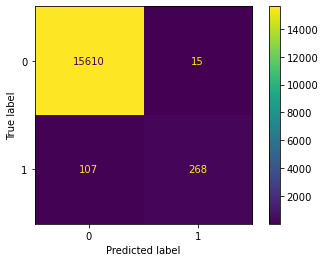

In [83]:
ConfusionMatrixDisplay(confusion_matrix(test_y, modxgbtest_class)).plot()

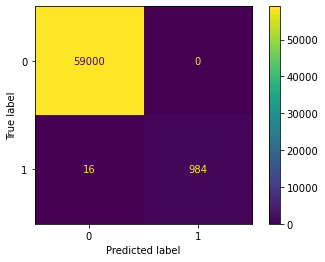

In [85]:
modxgbtrain_class = pd.DataFrame(modxgbtrain_pred)
modxgbtrain_class[(modxgbtrain_class > 0.5)] = 1
modxgbtrain_class[(modxgbtrain_class <= 0.5)] = 0
ConfusionMatrixDisplay(confusion_matrix(train_y, modxgbtrain_class)).plot()

In [86]:
a, b, c = roc_curve(modxgbtest_pred, test_y)
print("AUC FOR TESTING DATA", roc_auc_score(modxgbtest_pred, test_y))

AUC FOR TESTING DATA 0.9700942757172976


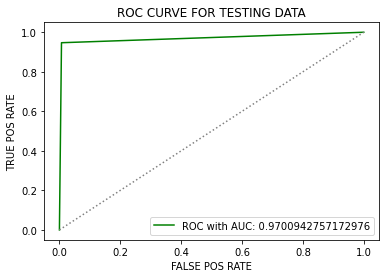

In [87]:
plt.plot(a, b, color='green', label='ROC with AUC: ' + str(roc_auc_score(modxgbtest_pred, test_y)))
plt.plot([0, 1], [0, 1], color='grey', linestyle = 'dotted')
plt.xlabel('FALSE POS RATE')
plt.ylabel('TRUE POS RATE')
plt.title('ROC CURVE FOR TESTING DATA')
plt.legend()
plt.show()

In [89]:
a, b, c = roc_curve(modxgbtrain_pred, train_y)
print("AUC FOR TRAINING DATA", roc_auc_score(modxgbtrain_pred, train_y))

AUC FOR TRAINING DATA 0.9998644435407348


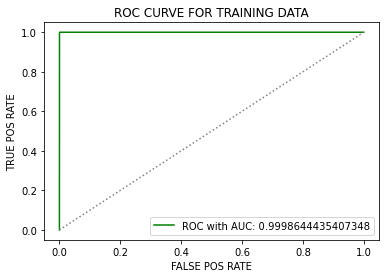

In [90]:
plt.plot(a, b, color='green', label='ROC with AUC: ' + str(roc_auc_score(modxgbtrain_pred, train_y)))
plt.plot([0, 1], [0, 1], color='grey', linestyle = 'dotted')
plt.xlabel('FALSE POS RATE')
plt.ylabel('TRUE POS RATE')
plt.title('ROC CURVE FOR TRAINING DATA')
plt.legend()
plt.show()

<h3>(f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your
data to compensate for class imbalance.4 Train XGBosst with L1-penalized logistic regression at each node using the pre-processed data and repeat 2e. Do not
forget that there is a right and a wrong way of cross validation here. Compare
the uncompensated case with SMOTE case.


In [92]:
osm = SMOTE()
smotetrain_X, smotetrain_y = sm.fit_resample(train_X, train_y)

In [97]:
smotexgb = xgb.XGBRegressor(objective='reg:logistic', reg_alpha=finalalpha)
smotexgb = smotexgb.fit(smotetrain_X, smotetrain_y)

In [98]:
smotexgbtrain_pred= smotexgb.predict(train_X)
smotexgbtest_pred = smotexgb.predict(test_X)

In [99]:
print("SMOTE DATA train error with xgb: ", mean_squared_error(train_y, smotexgbtrain_pred))

SMOTE DATA train error with xgb:  6.739014107667534e-05


In [100]:
print("SMOTE DATA test error with xgb: ", mean_squared_error(test_y, smotexgbtest_pred))

SMOTE DATA test error with xgb:  0.016568496888920137


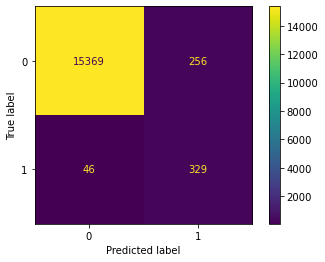

In [104]:
sm_df = pd.DataFrame(smotexgbtest_pred)
sm_df[(sm_df > 0.5)] = 1
sm_df[(sm_df <= 0.5)] = 0
ConfusionMatrixDisplay(confusion_matrix(test_y, sm_df)).plot()

In [105]:
a, b, c = roc_curve(smotexgbtest_pred, test_y)
print("AUC FOR TESTING DATA", roc_auc_score(smotexgbtest_pred, test_y))

AUC FOR TESTING DATA 0.7797045280016411


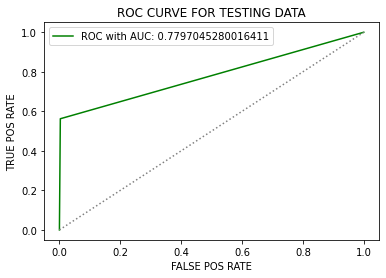

In [106]:
plt.plot(a, b, color='green', label='ROC with AUC: ' + str(roc_auc_score(smotexgbtest_pred, test_y)))
plt.plot([0, 1], [0, 1], color='grey', linestyle = 'dotted')
plt.xlabel('FALSE POS RATE')
plt.ylabel('TRUE POS RATE')
plt.title('ROC CURVE FOR TESTING DATA')
plt.legend()
plt.show()

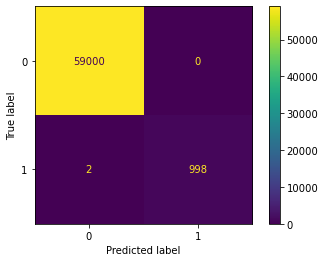

In [109]:
sm_dftrain = pd.DataFrame(smotexgbtrain_pred)
sm_dftrain[(sm_dftrain > 0.5)] = 1
sm_dftrain[(sm_dftrain <= 0.5)] = 0
ConfusionMatrixDisplay(confusion_matrix(train_y, sm_dftrain)).plot()

In [110]:
a, b, c = roc_curve(smotexgbtrain_pred, train_y)
print("AUC FOR TRAINING DATA", roc_auc_score(smotexgbtrain_pred, train_y))

AUC FOR TRAINING DATA 0.9999830514219856


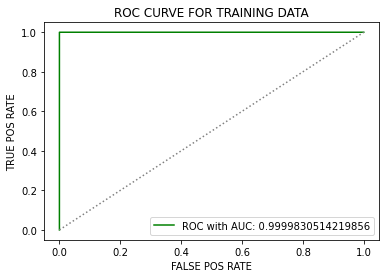

In [111]:
plt.plot(a, b, color='green', label='ROC with AUC: ' + str(roc_auc_score(smotexgbtrain_pred, train_y)))
plt.plot([0, 1], [0, 1], color='grey', linestyle = 'dotted')
plt.xlabel('FALSE POS RATE')
plt.ylabel('TRUE POS RATE')
plt.title('ROC CURVE FOR TRAINING DATA')
plt.legend()
plt.show()

<h3>2. ISLR 6.6.3


a) -> iv) Steadily decrease as model is becoming more flexible because the coefficients are getting reduced to their least square estimates <br>
b) -> ii) first decrease and then increase because it starts with more flexibility and then ends up overfitting.<br>
c) -> iii) Steady increase as more flexibility leads to more variance.<br>
d) -> iv) Decrease steadily as bias is inverselt proportional to flexibility<br> 
e) -> v) Irreducible error is independent of error and hence no change<br>

<h3>3. ISLR, 6.6.5


a) using: (x11=x12=x1 and x21=x22=x2), the ridge regression problem seeks to minimize
(y1−β^1x1−β^2x1)^2+(y2−β^1x2−β^2x2)^2+λ(β^21+β^22).<br>
b)β^1(x21+x22+λ)+β^2(x21+x22)=y1x1+y2x2
and
β^1(x21+x22)+β^2(x21+x22+λ)=y1x1+y2x2.<br>
By substracting the two expressions above we get β^1=β^2.<br>
c) (y1−β^1x1−β^2x1)2+(y2−β^1x2−β^2x2)2+λ(|β^1|+|β^2|)<br>
d)
(y1−β^1x1−β^2x1)2+(y2−β^1x2−β^2x2)2 subject to |β^1|+|β^2|≤s.<br>
(x11=x12=x1, x21=x22=x2, x1+x2=0 and y1+y2=0),
we have:
<br>2[y1−(β^1+β^2)x1]2≥0.<br>
solution : β^1+β^2=y1/x1

<h3>4. ISLR 8.4.5

majoritry vote: 6 vs 4 –> red
avg. prob.: P(Class is Red|X) = 4.5/10 = 0.45 –> green